<a href="https://colab.research.google.com/github/vubanc/BikeTimeSeriesAnalysis/blob/main/Classical_TSAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Classical Time Series Forecasting**

In this notebook, classical time series forecasting models were used to forecast bike trips of a bikesharing program in Fort Smith, Arkansas. The data was collected between the months of May 2022 and August 2023. Time series analysis was conducted on monthly as well as daily levels. The notebook will be updated as new data is collected.

### **Importing the Libraries and Notebooks**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from datetime import timedelta
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Work/Bikesharing/CombinedRentals_AllStations.csv")
df.head(2)

,index,id,user,user_id,user_phone,start_station,start_time,start_time_local,end_station,end_time,end_time_local,kilometers,miles,message_count,type,duration (seconds),rating,device_id,bike_type,Date
0,1,34ac1576-891f-4aca-a570-31db6160fd6f,Dara Ochoa,2112677d-b644-4cb8-866d-58f52b932f76,14792852353,Riverfront Park,2023-08-02 01:09:31.952446+00:00,2023-08-01 19:09:31.952446-06:00,Riverfront Park,2023-08-02 01:10:19.952446+00:00,2023-08-01 19:10:19.952446-06:00,NaN,NaN,130,22,48.0,NaN,74164be4e769c0ff30f08acb19724fa186d89b71913e9b...,Regular Bike,2023-08-01
1,2,dc96b3e6-f607-452b-ad18-79ea96e033d9,Gervon Pennington,79ea58b0-0988-47da-b963-a11a52a94f04,19035560048,Riverfront Park,2023-08-02 00:48:53.349677+00:00,2023-08-01 18:48:53.349677-06:00,Riverfront Park,2023-08-02 01:24:14.349677+00:00,2023-08-01 19:24:14.349677-06:00,4.482,2.78498,41,22,2121.0,NaN,fMV1Kdc8Km,Regular Bike,2023-08-01


### **EDA & Data Preprocessing**

In [ ]:
#Data Manipulation (monthly trips)
df.rename(columns={"Date":"date"}, inplace=True)
df["month"] = pd.to_datetime(df["date"]).dt.strftime("%Y-%m")
df_monthlyTrips = df.groupby("month", as_index=False)["id"].count()
df_monthlyTrips.rename(columns={"id":"trip_count"}, inplace=True)
df_monthlyTrips.set_index("month", inplace=True)
df_monthlyTrips.head(2)

,trip_count
month,
2022-05,364
2022-06,316


In [ ]:
#Data Manipulation (daily trips)
min_date = df["date"].min()
max_date = df["date"].max()
dates = pd.DataFrame(pd.date_range(start=min_date, end=max_date))
dates.rename(columns={0:"date"}, inplace=True)
dates["date"] = dates.date.dt.strftime("%Y-%m-%d")
df = pd.merge(df, dates, how="right", on="date")
df.sort_values(by = ["date", "start_time"], inplace=True, ascending=[True,True])

df_dailyTrips = df.groupby("date", as_index=False)["id"].count()
df_dailyTrips.rename(columns={"id":"trip_count"}, inplace=True)
df_dailyTrips.date = pd.to_datetime(df_dailyTrips.date)
df_dailyTrips.set_index("date", inplace=True)
df_dailyTrips.head(2)

,trip_count
date,
2022-05-02,2
2022-05-03,14


Trend

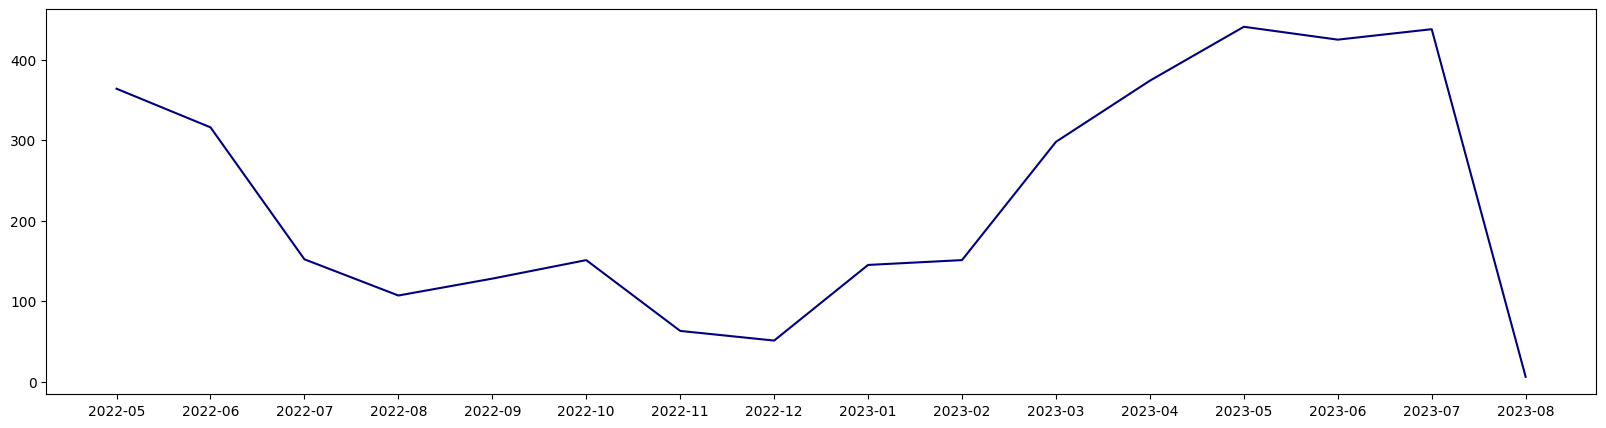

In [ ]:
#Monthly Trend
fig, axs = plt.subplots(1,1, figsize=(20,5))
plt.plot(df_monthlyTrips['trip_count'], color="navy")

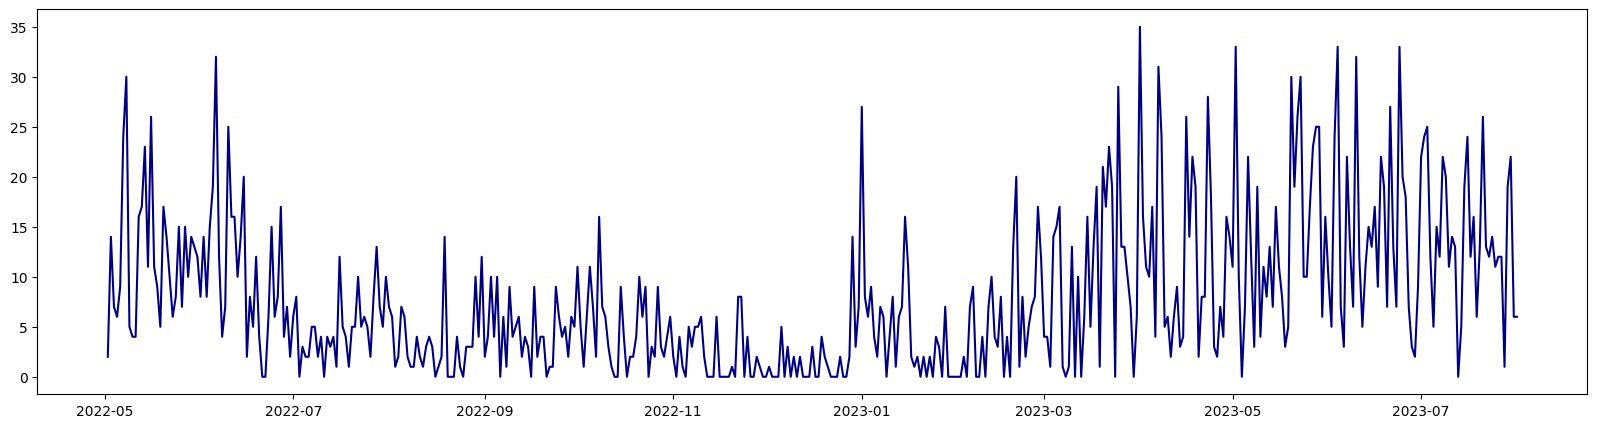

In [ ]:
#Daily Trend
fig, axs = plt.subplots(1,1, figsize=(20,5))
plt.plot(df_dailyTrips['trip_count'], color="navy")

Autocorrelation

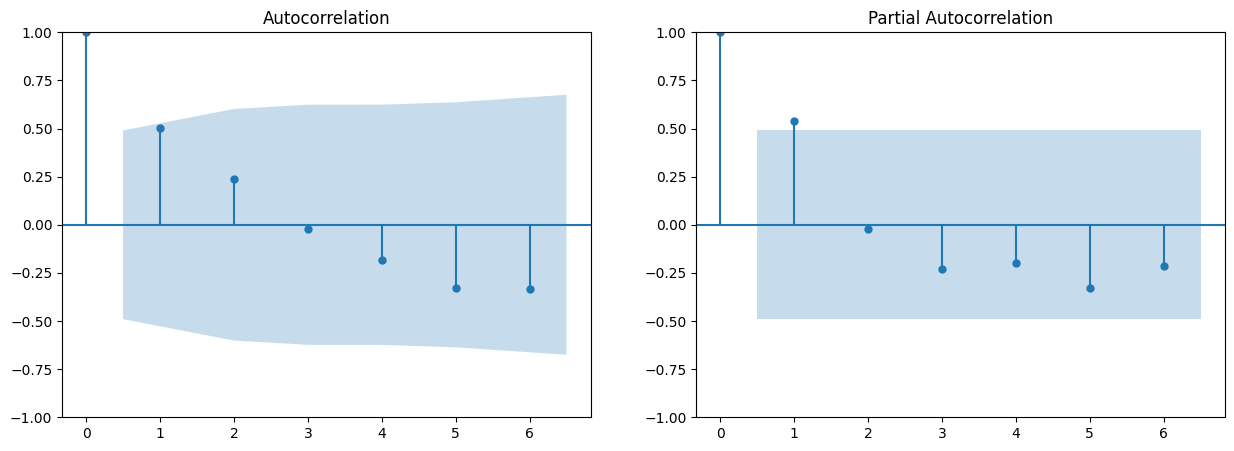

In [ ]:
#ACF & PACF plots(monthly)
fig, axs = plt.subplots(1,2,figsize=(15,5))
plot_acf(x=df_monthlyTrips.trip_count, ax=axs[0], lags=6)
plot_pacf(x=df_monthlyTrips.trip_count, ax=axs[1], lags=6)
plt.show()

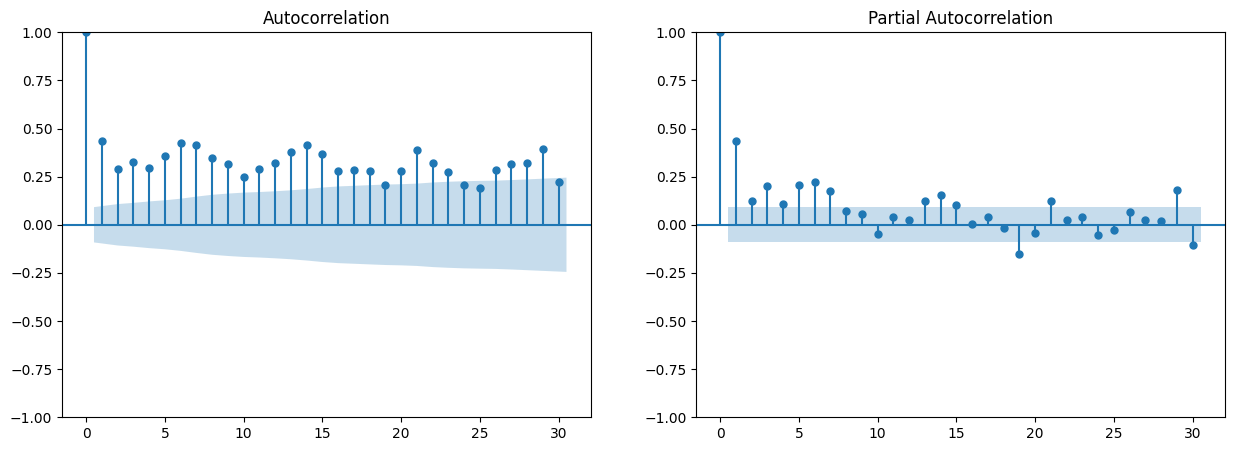

In [ ]:
#ACF & PACF plots (daily)
fig, axs = plt.subplots(1,2,figsize=(15,5))
plot_acf(x=df_dailyTrips.trip_count, ax=axs[0], lags=30)
plot_pacf(x=df_dailyTrips.trip_count, ax=axs[1], lags=30)
plt.show()

Stationarity

In [ ]:
#Augmented Dickey-Fuller Test
result = adfuller(df_monthlyTrips)
print(f"The ADF test statistic for monthly trips: {result[0]}")
print(f"The ADF p-value for monthly trips: {result[1]}")

The ADF test statistic for monthly trips: -34.16289988739043
The ADF p-value for monthly trips: 0.0


In [ ]:
#Augmented Dickey-Fuller Test
result = adfuller(df_dailyTrips)
print(f"The ADF test statistic for daily trips: {result[0]}")
print(f"The ADF p-value for daily trips: {result[1]}")

The ADF test statistic for daily trips: -1.967538455776848
The ADF p-value for daily trips: 0.30098516341276804


**From the ADF tests, two observations can be made:**
*   The monthly data is stationary and time-series models such as AR, MA or ARMA can be directly applied without differencing.
*   The daily data is not stationary. Hence, an ARIMA model with a 'd' parameter needs to be applied.



Before applying differencing, it is important to find out the minimum number of differencing steps that needs to be applied.

In [ ]:
#Applying differencing to dailyTrips
df_dailyTrips["diff_trip_count"] = df_dailyTrips['trip_count'].diff().fillna(0).astype(int)
df_dailyTrips.head(5)

,trip_count,diff_trip_count
date,,
2022-05-02,2,0
2022-05-03,14,12
2022-05-04,7,-7
2022-05-05,6,-1
2022-05-06,9,3


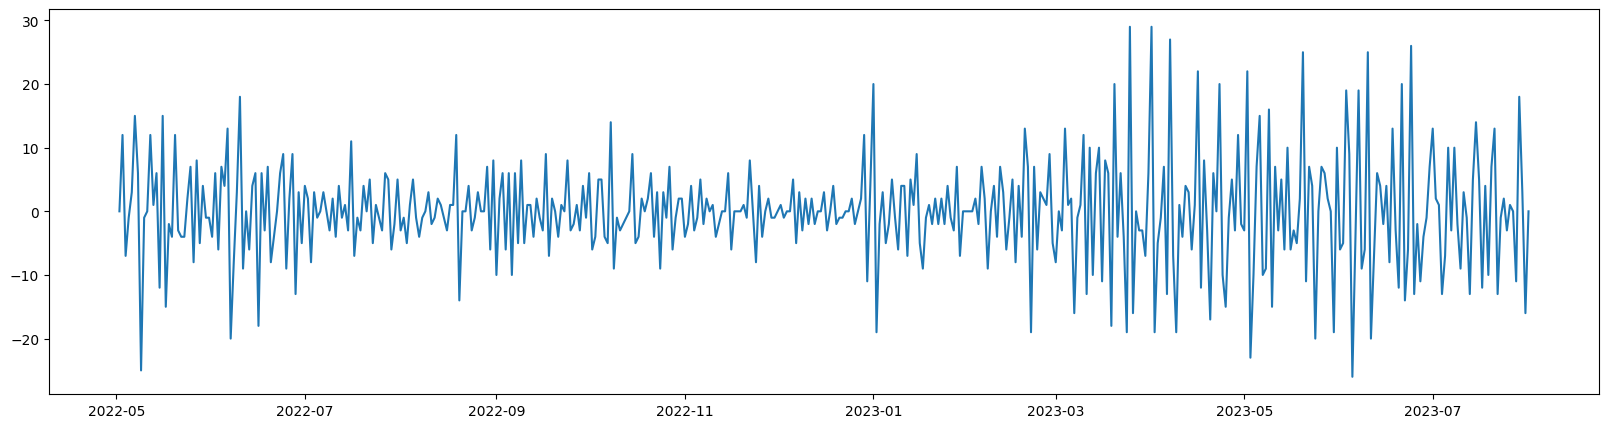

In [ ]:
#Daily data after applying the transformation
fig = plt.figure(figsize=(20,5))
plt.plot(df_dailyTrips.diff_trip_count)

In [ ]:
#Augmented Dickey-Fuller Test on the transformed data
result = adfuller(df_dailyTrips.diff_trip_count)
print(f"The ADF test statistic is: {result[0]}")
print(f"The ADF p-value is: {result[1]}")

The ADF test statistic is: -6.480879566160753
The ADF p-value is: 1.2959848279813883e-08


The ADF test suggests that applying differencing once is enough to make the data stationary. Hence, an ARIMA model with d=1 should be sufficient.

## **ARIMA Model Fitting**

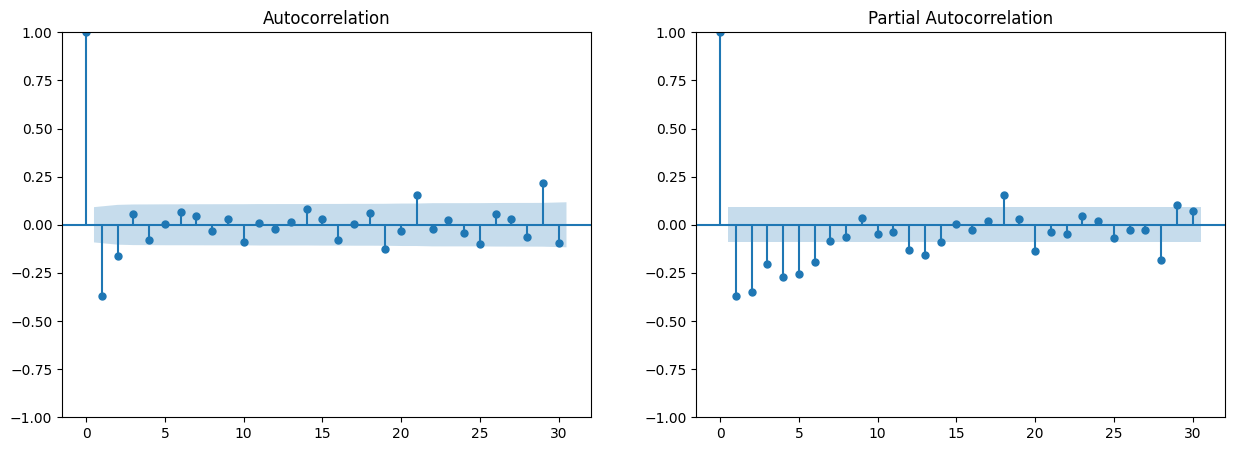

In [ ]:
#ACF and PACF for transformed daily data
fig, axs= plt.subplots(1,2, figsize=(15,5))
plot_acf(x=df_dailyTrips.diff_trip_count, ax=axs[0], lags=30)
plot_pacf(x=df_dailyTrips.diff_trip_count, ax=axs[1], lags=30)
plt.show()

The ACF and PACF plots suggest that an ARIMA model of order (6,1,1) should fit the daily data well.

In [ ]:
#Training and testing data
df_train_monthly = df_monthlyTrips[["trip_count"]][:"2022-12"]
df_test_monthly = df_monthlyTrips[["trip_count"]]["2023-01":"2023-07"]

df_train_daily = df_dailyTrips[["trip_count"]][:'2023-06-30']
df_test_daily = df_dailyTrips[["trip_count"]]['2023-07-01':]

In [ ]:
#Fixed window predictions (monthly)
#monthly_model = AutoReg(endog=df_train_monthly, lags=1).fit()
#monthly_predictions = monthly_model.predict(start=0, end=len(df_monthlyTrips)-1)

In [ ]:
#Fixed window predictions (daily)
#daily_model = ARIMA(endog=df_train_daily.asfreq("D"), order=(6,1,2), freq='D').fit()
#daily_predictions = daily_model.predict(start=0, end=len(df_dailyTrips)-1)

In [ ]:
#Rolling window origin predictions (monthly)
monthly_predictions = {'month':[], 'trip_count':[]}
for month in df_test_monthly.index:
  train_end = list(df_monthlyTrips.index).index(month)
  train_data = df_monthlyTrips[["trip_count"]][:train_end] #train_end here is a numeric index. Hence, the last one will be excluded
  monthly_model = ARIMA(endog=train_data, order=(1,0,1)).fit()
  monthly_predictions['month'].append(month)
  monthly_predictions['trip_count'].append(monthly_model.forecast().astype(int))

monthly_predictions = pd.DataFrame(monthly_predictions).set_index('month')
print(monthly_model.summary())

                               SARIMAX Results                                
Dep. Variable:             trip_count   No. Observations:                   14
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -79.871
Date:                Tue, 08 Aug 2023   AIC                            167.742
Time:                        18:35:47   BIC                            170.298
Sample:                    05-01-2022   HQIC                           167.505
                         - 06-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        274.7706    140.921      1.950      0.051      -1.429     550.970
ar.L1          0.7380      0.298      2.480      0.013       0.155       1.321
ma.L1          0.3970      0.566      0.702      0.4

In [ ]:
#Rolling window origin predictions (daily)
daily_predictions = {'date':[], 'trip_count':[]}

for date in df_test_daily.index:
  daily_predictions['date'].append(date)

  train_data = df_dailyTrips[["trip_count"]][:date-timedelta(days=1)]
  train_data = train_data.asfreq('D')
  daily_model = ARIMA(endog=train_data, order=(6,1,1), freq='D').fit()
  prediction = daily_model.forecast().astype(int)
  daily_predictions['trip_count'].append(prediction)

daily_predictions = pd.DataFrame(daily_predictions).set_index('date')
print(daily_model.summary())

                               SARIMAX Results                                
Dep. Variable:             trip_count   No. Observations:                  456
Model:                 ARIMA(6, 1, 1)   Log Likelihood               -1479.845
Date:                Tue, 08 Aug 2023   AIC                           2975.690
Time:                        18:32:22   BIC                           3008.652
Sample:                    05-02-2022   HQIC                          2988.675
                         - 07-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1024      0.054      1.887      0.059      -0.004       0.209
ar.L2         -0.1363      0.048     -2.854      0.004      -0.230      -0.043
ar.L3         -0.0158      0.048     -0.329      0.7

## **ARIMA Model Evaluation**

Ideally, the residuals from a time-series model should be white noise; the residuals should not contain any patterns that was not captured by the model. In order to be white noise, the residuals should be centered around 0 and an ADF test on the residuals should have p-value < 0.05.

The mean of the residuals is: -9.370987358652734
p-value for ADF test of the residuals is: 0.058547892464674275


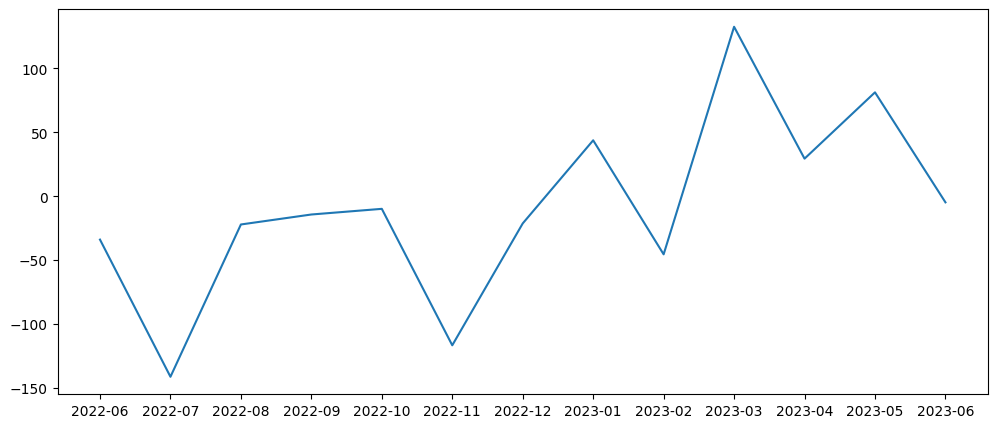

In [ ]:
#Checking for white noise in the residuals (monthly)
residuals =  monthly_model.resid[1:]
plt.figure(figsize=(12,5))
plt.plot(residuals)
print(f"The mean of the residuals is: {residuals.mean()}")
print(f"p-value for ADF test of the residuals is: {adfuller(residuals)[1]}")

plt.show()

The ARIMA model was not able to capture some patterns in the monthly data since the mean is -9.37.

The mean of the residuals is: 0.11409478543373867
p-value for ADF test of the residuals is: 0.0


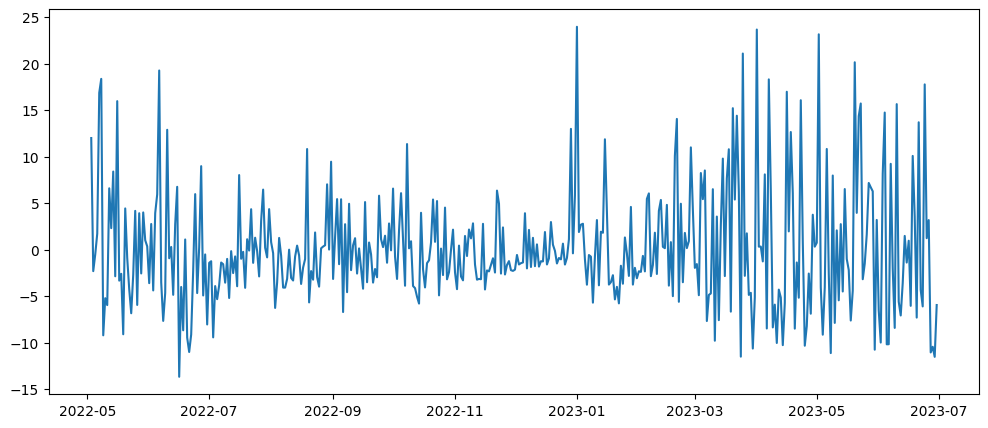

In [ ]:
#Checking for white noise in the residuals (daily)
residuals = daily_model.resid[1:]
plt.figure(figsize=(12,5))
plt.plot(residuals)
print(f"The mean of the residuals is: {residuals.mean()}")
print(f"p-value for ADF test of the residuals is: {adfuller(residuals)[1]}")
plt.show()

The p-values from the ADF tests indicate that the daily residuals are white noise since the mean is almost 0 and the p-value for the ADF test less than 0.05.

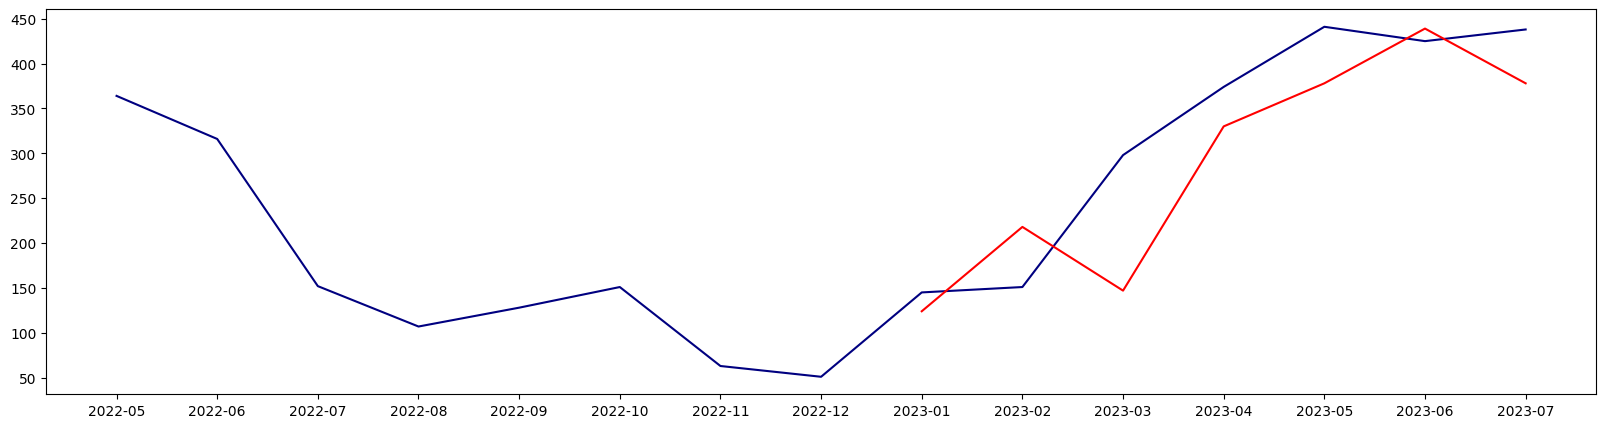

In [ ]:
#True trip count vs predicted trip count (monthly)
plt.figure(figsize=(20,5))
plt.plot(df_monthlyTrips[:"2023-07"], color='navy')
plt.plot(monthly_predictions.astype(int), color='red')

In [ ]:
#Root mean-squared error (monthly)
rmse_monthly = np.sqrt(mean_squared_error(df_test_monthly, monthly_predictions.astype(int)))
print(f"rmse for monthly trip predictions: {rmse_monthly}")

rmse for monthly trip predictions: 73.12611415512636


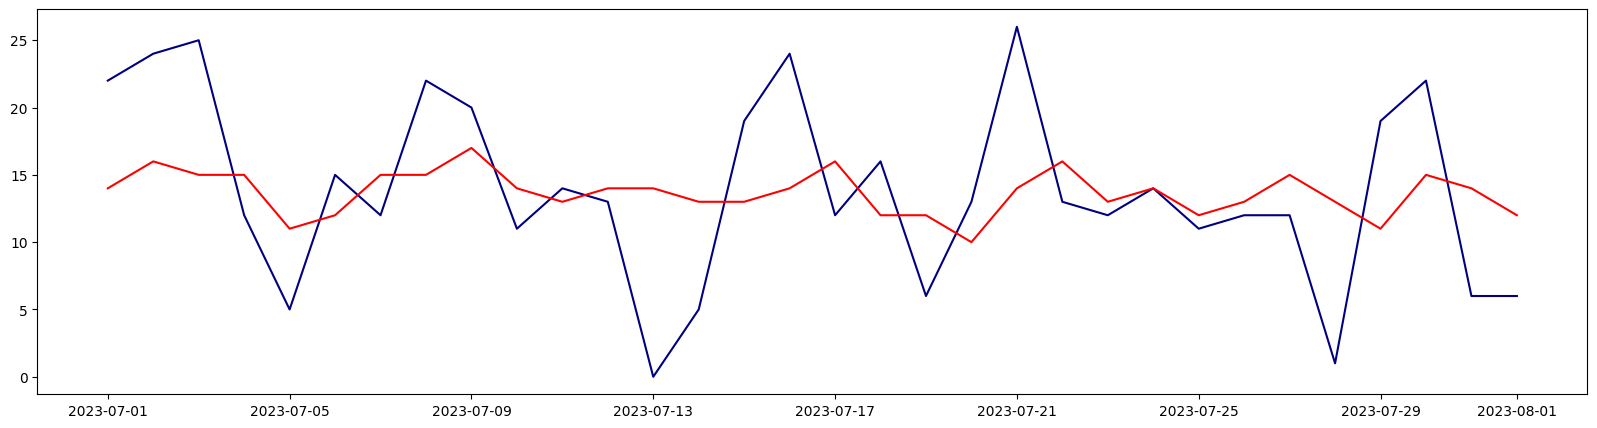

In [ ]:
#True trip count difference vs predicted trip count difference (daily)
plt.figure(figsize=(20,5))
plt.plot(df_dailyTrips["trip_count"]["2023-07-01":], color="navy")
plt.plot(daily_predictions["trip_count"]["2023-07-01":], color="red")
plt.show()

In [ ]:
#Root mean-squared error (daily)
rmse = np.sqrt(mean_squared_error(df_test_daily, daily_predictions["trip_count"]["2023-06-30":].astype(int)))
print(f"rmse for daily trip predictions: {rmse}")

rmse for daily trip predictions: 6.507207542410185
